In [234]:

import numpy as np
%pylab inline 
import nltk
import ujson
import re
import time
import progressbar
from sklearn.decomposition import PCA
import pandas as pd
from __future__ import print_function
from six.moves import zip, range 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim, os, re, pymongo, itertools, nltk, snowballstemmer
nltk.download('stopwords') #download the latest stopwords


from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/agshreya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
df = pd.read_csv("TopAns.csv")
#ques_body = df["Ques_Body"]
df = df.dropna()

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13707 entries, 57 to 88137
Data columns (total 14 columns):
Unnamed: 0       13707 non-null int64
Ques_Id          13707 non-null int64
Ques_UserId      13707 non-null float64
Ques_Date        13707 non-null object
Ques_Score       13707 non-null int64
Ques_Title       13707 non-null object
Ques_Body        13707 non-null object
Tag              13707 non-null object
Ques_TagCount    13707 non-null int64
Ans_Id           13707 non-null float64
Ans_UserId       13707 non-null float64
Ans_Date         13707 non-null object
Ans_Score        13707 non-null float64
Ans_Body         13707 non-null object
dtypes: float64(4), int64(4), object(6)
memory usage: 2.2+ MB


In [111]:
def f(row):
    if "<code>" in row["Ques_Body"]:
        val = 1
    else:
        val = 0
    return val
def p(row):
    if "<a href=" in row["Ques_Body"]:
        val1 = 1
    else:
        val1 = 0
    return val1
def q(row):
    return len(row["Ques_Title"])

In [112]:
df['has_code'] = df.apply(f,axis = 1)
df['has_link'] = df.apply(p,axis = 1)
df["Ques_title_len"] = df.apply(q,axis = 1)

In [113]:
users =  df.Ans_UserId

In [114]:
users

57        57695.0
128       22656.0
151       57695.0
153       23354.0
156       23354.0
157       22656.0
162       22656.0
163       22656.0
172       23354.0
175       22656.0
176       22656.0
179       23354.0
180       23354.0
182       22656.0
183       23354.0
188       23354.0
193       23354.0
194       22656.0
195       23354.0
198       22656.0
199       22656.0
200       22656.0
208       23354.0
214       23354.0
221       23354.0
223       22656.0
229       23354.0
230       22656.0
237       22656.0
239       23354.0
           ...   
86816    115145.0
86913     22656.0
86969    115145.0
87062    115145.0
87147     19068.0
87236    115145.0
87239     23354.0
87241     19068.0
87377    115145.0
87478    115145.0
87494     34397.0
87553     19068.0
87568    157247.0
87572    157247.0
87608    139985.0
87626    157247.0
87653    115145.0
87658    115145.0
87659    115145.0
87660    115145.0
87661    115145.0
87664    157247.0
87785     57695.0
87786     19068.0
87787     

In [255]:
df.apply(lambda x: x.astype(str).str.lower())

,Unnamed: 0,Ques_Id,Ques_UserId,Ques_Date,Ques_Score,Ques_Title,Ques_Body,Tag,Ques_TagCount,Ans_Id,Ans_UserId,Ans_Date,Ans_Score,Ans_Body,has_code,has_link,Ques_title_len,Ques_Body_upd
57,58,65200,9195.0,2008-09-15t18:01:35z,90,how do you crash a jvm?,<p>i was reading a book on programming skills ...,java,2,799757.0,57695.0,2009-04-28t20:47:33z,1.0,<p>if you want to pretend you have run out of ...,0,0,23,i was reading a book on programming skills whe...
128,129,139260,5795.0,2008-09-26t12:50:46z,15,writing xml files using xmltextwriter with iso...,<p>i'm having a problem writing norwegian char...,c#,5,139441.0,22656.0,2008-09-26t13:16:16z,13.0,<p>both your streamwriter and your streamreade...,1,0,62,i'm having a problem writing norwegian charact...
151,152,146850,14788.0,2008-09-28t22:00:33z,152,c++ versus d,"<p>is the <a href=""http://www.digitalmars.com/...",java,4,623253.0,57695.0,2009-03-08t07:59:15z,3.0,<p>one approach is to search for jobs in your ...,0,1,12,is the d language a credible alternative to ja...
153,154,151000,11574.0,2008-09-29t22:28:27z,4,finalizers and dispose,<p>i've got a class named <code>backgroundwork...,c#,5,152033.0,23354.0,2008-09-30t07:03:39z,3.0,"<p>out of interest, any reason this couldn't u...",1,0,22,i've got a class named that has a thread cons...
156,157,152900,21299.0,2008-09-30t12:51:19z,4,.net xmldocument loadxml and entities,"<p>when loading xml into an xmldocument, i.e.<...",c#,3,152936.0,23354.0,2008-09-30t13:01:28z,4.0,<p>what are you writing it to? a textwriter? a...,0,0,37,"when loading xml into an xmldocument, i.e.\r\r..."
157,158,152900,21299.0,2008-09-30t12:51:19z,4,.net xmldocument loadxml and entities,"<p>when loading xml into an xmldocument, i.e.<...",c#,3,152923.0,22656.0,2008-09-30t12:59:42z,2.0,<p>i confess things get a little confusing wit...,0,0,37,"when loading xml into an xmldocument, i.e.\r\r..."
162,163,155260,22459.0,2008-09-30t21:51:48z,6,"what is the ""< >"" syntax within c#",<p>i have been learning about the basics of c#...,c#,2,155295.0,22656.0,2008-09-30t21:59:55z,5.0,<p>it's <em>generics</em> - it's a form of typ...,1,0,34,i have been learning about the basics of c# bu...
163,164,155780,7418.0,2008-10-01t00:57:58z,6,safehandle in c#,<p>what is safehandle? how does it differ from...,c#,2,156326.0,22656.0,2008-10-01t05:23:10z,6.0,<p>another way of looking at it: with safehand...,0,0,16,what is safehandle? how does it differ from in...
172,173,166360,21603.0,2008-10-03t11:09:10z,2,writing a generic class to handle built-in types,"<p>not too practical maybe, but still interest...",c#,4,166369.0,23354.0,2008-10-03t11:12:29z,5.0,<p>for this you need generic maths. luckily <a...,0,0,48,"not too practical maybe, but still interesting..."
175,176,168150,7862.0,2008-10-03t18:10:40z,5,"other than for linq queries, how do you use an...",<p>i've been trying to get up to speed on some...,c#,2,168542.0,22656.0,2008-10-03t19:37:05z,3.0,<p>occasionally i suspect it may be useful to ...,0,1,66,i've been trying to get up to speed on some of...


In [123]:
import re

In [153]:
p = re.compile('<code>.*?</code>')
p.sub('', 'This is a code. <code> sdfdsfryrdsdgrdtesvdffljdshfksndjbhgsrfne </code> Gaaaaah <code> dgdffsdf </code>')

#p.sub('', df.Ques_Body.ix[1])

'This is a code.  Gaaaaah '

In [256]:
def f1(row):
    p = re.compile('<code>.*?</code>')
    return p.sub('',row["Ques_Body"])


In [155]:
def f2(row):
    p = re.compile('<a.*?>')
    return p.sub('',row["Ques_Body_upd"])

In [257]:
def f3(row):
    p = re.compile('<.*?>')
    return p.sub('',row["Ques_Body_upd"])

In [355]:
def f4(row):
    p = re.compile('(\n|\r|/)')
    return p.sub('',row["Ques_Body_upd"])

In [259]:
def f5(row):
    p = re.compile('(0|1|2|3|4|5|6|7|8|9)')
    return p.sub('',row["Ques_Body_upd"])

In [260]:
def f6(row):
    p = re.compile('(java|c#|php|javascript|android)')
    return p.sub('',row["Ques_Body_upd"])

In [358]:
df['Ques_Body_upd'] = df.apply(f1,axis = 1)
df['Ques_Body_upd'] = df.apply(f2,axis = 1)
df['Ques_Body_upd'] = df.apply(f3,axis = 1)
df['Ques_Body_upd'] = df.apply(f4,axis = 1)
df['Ques_Body_upd'] = df.apply(f5,axis = 1)
df['Ques_Body_upd'] = df.apply(f6,axis = 1)

In [363]:
df[df['Ques_Body_upd'].str.contains("!")]
                                    

,Unnamed: 0,Ques_Id,Ques_UserId,Ques_Date,Ques_Score,Ques_Title,Ques_Body,Tag,Ques_TagCount,Ans_Id,Ans_UserId,Ans_Date,Ans_Score,Ans_Body,has_code,has_link,Ques_title_len,Ques_Body_upd,stemmed_text_data
193,194,180930,410357.0,2008-10-08T00:19:17Z,0,Object Initializer syntax to produce correct Json,<p>I am attempting to use linq to shape list o...,c#,3,181506.0,23354.0,2008-10-08T06:05:56Z,1.0,"<p>In json, the ""c"" in ""c"" : ""One"" is the prop...",1,0,49,I am attempting to use linq to shape list of d...,attempt use linq shape list data particular sh...
198,199,185690,3279.0,2008-10-09T02:21:46Z,4,How to inflate a file with zlib.NET?,"<p>I'm using the <a href=""http://www.component...",c#,4,185736.0,22656.0,2008-10-09T02:38:56Z,6.0,"<p>Other than failing to use a ""using"" stateme...",1,1,36,I'm using the zlib.NET library to try and infl...,i m use librari tri inflat file compress zlib ...
237,238,210020,4555.0,2008-10-16T19:54:15Z,2,Suspending and notifying threads when there is...,<p>I have multiple threads (C# application run...,c#,2,210060.0,22656.0,2008-10-16T20:01:48Z,4.0,<p>As well as the WaitHandle classes pointed o...,1,0,57,I have multiple threads (C# application runnin...,multipl thread c applic run run need communi...
382,383,325020,26086.0,2008-11-28T03:26:39Z,4,JavaScriptSerializer C# and Generics (newbie m...,<p>WinForms C#.. am getting some JSON in the f...,c#,1,325104.0,23354.0,2008-11-28T05:32:16Z,1.0,<p>Edit: The following works with <code>DataCo...,1,0,63,WinForms C#.. am getting some JSON in the form...,winform get json format messag tri deserialis...
383,384,326390,20654.0,2008-11-28T18:32:07Z,858,How do I create a Java string from the content...,<p>I've been using the idiom below for some ti...,java,4,326531.0,22656.0,2008-11-28T19:56:35Z,34.0,"<p>That code will normalize line breaks, which...",1,0,58,I've been using the idiom below for some time ...,i ve use idiom time now seem least site i ve ...
384,385,326390,20654.0,2008-11-28T18:32:07Z,858,How do I create a Java string from the content...,<p>I've been using the idiom below for some ti...,java,4,2661480.0,57695.0,2010-04-18T07:34:29Z,14.0,<p>To read a File as binary and convert at the...,1,0,58,I've been using the idiom below for some time ...,i ve use idiom time now seem least site i ve ...
411,412,344630,28736.0,2008-12-05T17:44:08Z,3,Ignore ObsoleteAttribute Compiler Error,<p>I have an enumeration value marked with the...,c#,1,344635.0,22656.0,2008-12-05T17:46:29Z,2.0,<p>Private a separate constant somewhere like ...,1,0,39,I have an enumeration value marked with the fo...,enumer valu mark follow attribut second param...
457,458,374770,29544.0,2008-12-17T14:51:41Z,7,Chained IF structure,<p>Imagine this case where I have an object th...,c#,2,374776.0,23354.0,2008-12-17T14:53:34Z,43.0,<pre><code>if(myObject != null &amp;&amp; myOb...,1,0,20,Imagine this case where I have an object that ...,imagin case object need check properti \rhowev...
458,459,374770,29544.0,2008-12-17T14:51:41Z,7,Chained IF structure,<p>Imagine this case where I have an object th...,c#,2,374776.0,23354.0,2008-12-17T14:53:34Z,43.0,<pre><code>if(myObject != null &amp;&amp; myOb...,1,0,20,Imagine this case where I have an object that ...,imagin case object need check properti \rhowev...
459,460,374770,29544.0,2008-12-17T14:51:41Z,7,Chained IF structure,<p>Imagine this case where I have an object th...,java,2,374776.0,23354.0,2008-12-17T14:53:34Z,43.0,<pre><code>if(myObject != null &amp;&amp; myOb...,1,0,20,Imagine this case where I have an object that ...,imagin case object need check properti \rhowev...


In [ ]:

 
categories = data['index']
desc = data['description'].fillna('')
 
vectoriser = TfidfVectorizer()
features = vectoriser.fit_transform(desc)
 
features.shape
#(35182, 66023)
 
x, x_test, y, y_test = train_test_split(features,categories,test_size=0.2,train_size=0.8, random_state = 0)
 
clf = MultinomialNB().fit(x, y)
predicted = clf.predict(x_test)
 
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
 
    print('\n \n')
    print(classification_report(exp, pred))
 
printreport(y_test, predicted)

In [391]:
vectoriser = TfidfVectorizer()
features = vectoriser.fit_transform(df['Ques_Body_upd'])

In [392]:
features.shape

(13707, 62395)

In [433]:
X_train, X_test, y_train, y_test = train_test_split(features, users, test_size=0.20, random_state=0)

In [434]:
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)


In [435]:
from sklearn import metrics
metrics.f1_score(y_test, predicted, average='macro')

/Users/agshreya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.19523819838883799

In [436]:
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
 
    print('\n \n')
    print(classification_report(exp, pred))
 
printreport(y_test, predicted)

Predicted  19068.0   22656.0   29407.0   57695.0   115145.0  139985.0  \
Actual                                                                  
19068.0          90       113         0         0        49         0   
22656.0           0       577         0         0        26         1   
23354.0           0       193         0         0        11         0   
29407.0          18       160         2         0        32         0   
34397.0          18       152         0         0        26         0   
57695.0           0       231         0         1        22         0   
115145.0          0        21         0         0       489         0   
139985.0          1       179         0         0        64         4   
157247.0         59       168         0         0        30         0   

Predicted  157247.0  
Actual               
19068.0           0  
22656.0           0  
23354.0           0  
29407.0           1  
34397.0           0  
57695.0           0  
115145.0          0 

NameError: name 'classification_report' is not defined

In [404]:
#categories = [users]

In [437]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(9)
    target_names = categories
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy 0.425601750547
confusion matrix
 [[ 90 113   0   0   0   0  49   0   0]
 [  0 577   0   0   0   0  26   1   0]
 [  0 193   0   0   0   0  11   0   0]
 [ 18 160   0   2   0   0  32   0   1]
 [ 18 152   0   0   0   0  26   0   0]
 [  0 231   0   0   0   1  22   0   0]
 [  0  21   0   0   0   0 489   0   0]
 [  1 179   0   0   0   0  64   4   0]
 [ 59 168   0   0   0   0  30   0   4]]
(row=expected, col=predicted)


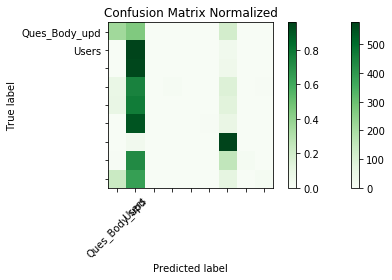

In [438]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
print('accuracy %s' % accuracy_score(y_test, predicted))

cm = confusion_matrix(y_test, predicted)
print('confusion matrix\n %s' % cm)
plot_confusion_matrix(cm)
print('(row=expected, col=predicted)')
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Confusion Matrix Normalized')

In [439]:
np.mean(predicted == y_test)    

0.42560175054704596

In [460]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
random_state = np.random.RandomState(0)
from sklearn.linear_model import SGDClassifier


In [461]:
text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                          ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=42,
                                                max_iter=5, tol=None)),
     ])

In [468]:
text_clf  = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False, intercept_scaling=1)
text_clf.fit(X_train, y_train)

NameError: name 'LinearSVC' is not defined

In [469]:

text_clf = SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=42,
                                                max_iter=5, tol=None)
text_clf.fit(X_train, y_train)  



SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [465]:
predicted = text_clf.predict(X_test)

In [466]:
np.mean(predicted == y_test)

0.5466812545587163

In [445]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [470]:
from sklearn.svm import SVC
clf_svc = SVC(kernel = 'linear', probability = True)
clf_svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [471]:
predicted_svc = clf_svc.predict(X_test)
accuracy_score(y_test, predicted_svc)

0.5900802334062728

accuracy 0.590080233406
confusion matrix
 [[167  15   2   9   4   3   4   0  48]
 [  2 497  11   8   7  47   7  23   2]
 [  4 132  50   6   3   6   0   2   1]
 [ 18  79   5  83   9   2   5   2  10]
 [ 18 102   4  10  27   5   8   3  19]
 [  1 108   1   2   4  95   3  40   0]
 [  1  17   0   1   0   2 488   0   1]
 [  2  99   4   0   0  49   9  83   2]
 [ 51  48   1   5  10  13   1   4 128]]
(row=expected, col=predicted)


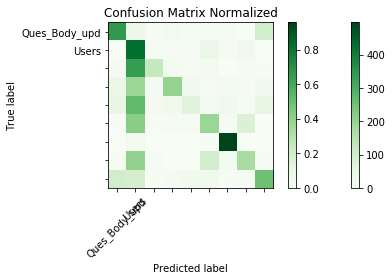

In [472]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
print('accuracy %s' % accuracy_score(y_test, predicted_svc))

cm = confusion_matrix(y_test, predicted_svc)
print('confusion matrix\n %s' % cm)
plot_confusion_matrix(cm)
print('(row=expected, col=predicted)')
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Confusion Matrix Normalized')

In [449]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


NameError: name 'n_classes' is not defined

In [328]:
stemmer = snowballstemmer.EnglishStemmer()

In [329]:
stop = stopwords.words('english')
#stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist))) 

In [364]:
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*df['Ques_Body_upd'].str.split(' ')))))).split(" "))
df['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in df['Ques_Body_upd'].str.lower().str.split(' ')]

In [285]:
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*X_test['Ques_Body_upd'].str.split(' ')))))).split(" "))
X_test['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in X_test['Ques_Body_upd'].str.lower().str.split(' ')]

/Users/agshreya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [286]:
X_test.head()

,Unnamed: 0,Ques_Id,Ques_UserId,Ques_Date,Ques_Score,Ques_Title,Ques_Body,Tag,Ques_TagCount,Ans_Id,Ans_UserId,Ans_Date,Ans_Score,Ans_Body,has_code,has_link,Ques_title_len,Ques_Body_upd,stemmed_text_data
21740,21741,17031330,1497454.0,2013-06-10T19:28:53Z,0,Jquery xml parse error,<p>I am using ajax to download an xml about Sh...,javascript,5,17031351.0,34397.0,2013-06-10T19:30:15Z,0.0,"<p>As you said in your question, you need to p...",1,1,22,I am using ajax to download an xml about Share...,using ajax download xml sharepoint search (pac...
8622,8623,7750190,833168.0,2011-10-13T06:23:40Z,2,"not a statement error, illegal start of type",<pre><code>import java.util.*;\r\n\r\npublic c...,java,1,7750201.0,22656.0,2011-10-13T06:25:11Z,7.0,<p>This is the immediate problem:</p>\r\n\r\n<...,1,0,44,import .util.*;\r\rpublic class ulang {\r\r ...,import .util.*;\r\rpublic class ulang {\r\r pu...
6723,6724,6137140,638868.0,2011-05-26T10:31:24Z,1,return a byte array from a java method,<p>I have a byte array which i am passing to a...,java,2,6137811.0,57695.0,2011-05-26T11:34:40Z,0.0,<p>If all you want is a String with the nibble...,1,0,38,I have a byte array which i am passing to a fu...,byte array passing function . swaps st bits nd...
10670,10671,9339950,1119970.0,2012-02-18T09:01:54Z,2,How to read a file to java lists?,<p>I have a very weird file in my company. It ...,java,3,9339961.0,57695.0,2012-02-18T09:05:00Z,2.0,<p>I would write a simple parser with a state ...,1,0,33,I have a very weird file in my company. It was...,"weird file company. generated program, written..."
3689,3690,3436280,764272.0,2010-08-08T22:12:22Z,7,Start / stop built-in Wi-Fi / USB tethering fr...,<p>How can I start or stop the built-in tether...,android,3,3436320.0,115145.0,2010-08-08T22:22:59Z,0.0,<p>There are no public APIs in the Android SDK...,0,0,54,How can I start or stop the built-in tethering...,start stop built-in tethering android . applic...


In [ ]:
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["text"] = list(map(lambda str: stemmer.stem(str.lower()), row["text"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["text"] = tokenizer(row["text"])
            row["tokenized_text"] = [] + row["text"]
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)



In [ ]:
ata = TwitterData_TokenStem(check)
check.tokenize()
check.stem()
check.processed_data.head(5)


In [365]:
minimum_count = 3
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*df['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
df['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in df['stemmed_text_data'].str.split(' ')]
df['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in df['stemmed_text_data']]

# run word2vec model and then save it
texts_stemmed = filter(None, [next_text.strip(' ').split(' ') for next_text in df['stemmed_text_data']])
w2vmodel_stemmed = gensim.models.Word2Vec(texts_stemmed, size=50, window=3, min_count=3, workers=4)

print(w2vmodel_stemmed)

In [289]:
print(w2vmodel_stemmed)

Word2Vec(vocab=6054, size=50, alpha=0.025)


In [290]:

X = w2vmodel_stemmed[w2vmodel_stemmed.wv.vocab]

In [291]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

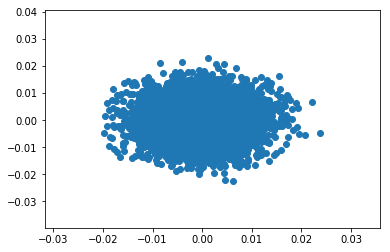

In [292]:

pyplot.scatter(result[:, 0], result[:, 1])

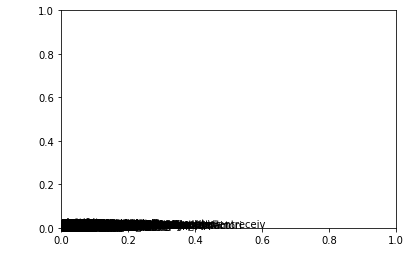

In [241]:

words = list(w2vmodel_stemmed.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [ ]:
model.save('model.bin')

#loading the model
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True) 

#getting the most similar words
model.most_similar(positive=['beautiful', 'world'], negative=['convert'], topn=1)

#finding the odd one out
model.doesnt_match("bullish holding stock".split())

#getting the vector for any word
model[word]

#finding the similarity between words
model.similarity('woman', 'man')

In [222]:
w2vmodel_stemmed.save('model.bin')

In [300]:
w2vmodel_stemmed.similarity('okay', 'minus')

0.064852949862120382

In [307]:
w2vmodel_stemmed.most_similar(positive=['socket'])

[('\r\r\r\ri', 0.6040989756584167),
 ('bytestohex', 0.55059415102005),
 ('findclass', 0.4803996682167053),
 ('propertychangedeventhandl', 0.4787951111793518),
 ('marshmallow', 0.47292962670326233),
 ('$discount', 0.4689738154411316),
 ('cor', 0.4625864624977112),
 ('type', 0.45874401926994324),
 ('player', 0.44715356826782227),
 ('ð¼ðµð½ñž', 0.43889278173446655)]

In [223]:
w2vmodel_stemmed['problem']


array([ -3.54199624e-03,   3.07448884e-03,  -4.14284272e-03,
        -4.67175571e-03,   3.35972116e-04,  -3.45080439e-03,
        -2.72713741e-03,  -3.65994964e-03,   1.45752751e-03,
         1.91679748e-03,   3.18164658e-03,  -1.80187495e-03,
         1.97946699e-03,   7.05882558e-04,   3.49603291e-03,
        -4.62187134e-04,   4.14559012e-03,   2.82828417e-03,
         1.30047975e-03,   9.02609667e-04,  -1.91671614e-04,
         4.99297224e-04,   3.79094295e-03,  -4.85630910e-04,
        -1.06823235e-03,   7.61305273e-04,  -1.80882437e-03,
         1.18526234e-03,  -4.14415123e-03,   7.82546340e-05,
         3.20302002e-04,   3.40702623e-04,  -3.21394275e-03,
         4.27393056e-03,  -1.57155527e-03,   1.12570764e-03,
        -4.02519992e-03,  -8.44920811e-04,  -3.76725127e-03,
        -2.52802740e-04,   2.32019462e-04,   1.80718649e-04,
         2.18541990e-03,   2.63200054e-05,  -3.38122202e-03,
        -4.32039466e-04,   4.05282434e-03,  -4.89182677e-03,
        -1.43190485e-03,

In [224]:
w2vmodel_stemmed.most_similar['problem']

TypeError: 'method' object is not subscriptable

In [242]:
# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

In [293]:


# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [w2vmodel_stemmed[w] for w in w2vmodel_stemmed.wv.vocab]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = w2vmodel_stemmed.wv.vocab

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6054 samples in 0.009s...
[t-SNE] Computed neighbors for 6054 samples in 3.824s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6054
[t-SNE] Computed conditional probabilities for sample 2000 / 6054
[t-SNE] Computed conditional probabilities for sample 3000 / 6054
[t-SNE] Computed conditional probabilities for sample 4000 / 6054
[t-SNE] Computed conditional probabilities for sample 5000 / 6054
[t-SNE] Computed conditional probabilities for sample 6000 / 6054
[t-SNE] Computed conditional probabilities for sample 6054 / 6054
[t-SNE] Mean sigma: 0.011165
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.649292
[t-SNE] Error after 1000 iterations: 4.165914
